# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [27]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

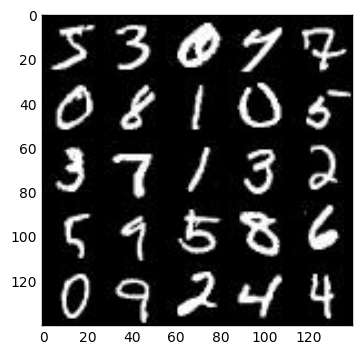

In [28]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

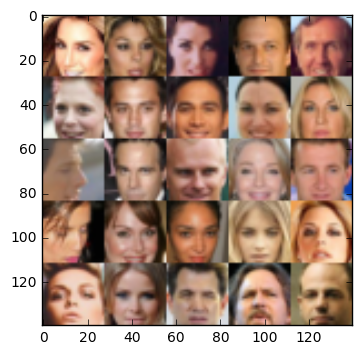

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Create model inputs
    im_tensor = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_tensor = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return im_tensor, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    drop = 0.1  # Drop-out rate
    
    # Set scope to allow re-use
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 image
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')  # 14 x 14 x 64 output
        lrelu1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU activation
        
        d1 = tf.layers.dropout(lrelu1, rate=drop)
        
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same')  # 7 x 7 x 128 output
        bn1 = tf.layers.batch_normalization(x2, training=True)  # Batch norm
        lrelu2 = tf.maximum(alpha * bn1, bn1)
        
        d2 = tf.layers.dropout(lrelu2, rate=drop)
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same')  # 4 x 4 x 256 output
        bn2 = tf.layers.batch_normalization(x3, training=True)  # Batch norm
        lrelu3 = tf.maximum(alpha * bn2, bn2)
        
        d3 = tf.layers.dropout(lrelu3, rate=drop)
        
        flat = tf.reshape(d3, (-1, 4*4*256))  # Flatten for use in fully connected layer
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    
    # Set scope to allow re-use
    with tf.variable_scope('generator', reuse = not is_train):
        # Start with fully connected layer with input noise
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it for use in transpose convolutional layers
        x1 = tf.reshape(x1, (-1, 7, 7, 512))  # 7 x 7 x 512 output
        bn1 = tf.layers.batch_normalization(x1, training=is_train)  # Batch norm
        lrelu1 = tf.maximum(alpha * bn1, bn1)  # Leaky ReLU activation
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='same')  # 14 x 14 x 256 output
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')  # 28 x 28 x 128 output
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer - strides=1 with same padding here means 28 x 28 x out_channel_dim output
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # Tanh activation for final putput of generator
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Get outputs from generator and discriminator
    gen = generator(input_z, out_channel_dim, is_train=True)
    disc_fake_out, disc_fake_logits = discriminator(gen, reuse=False)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=True)
    
    # Calculate losses for each - real ones smoothed for discriminator to 0.9 instead of 1.0
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits, labels=tf.ones_like(disc_real_out)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.zeros_like(disc_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.ones_like(disc_fake_out)))

    # Discriminator loss is sum of real and fake losses
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases from training variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizizing
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    tf.reset_default_graph()
    
    # Determine number of image channels
    out_channels = 0
    if data_image_mode == 'RGB':
        out_channels = 3
    else:
        out_channels = 1
    
    images_tensor, z_tensor, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) 
    d_loss, g_loss = model_loss(images_tensor, z_tensor, out_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))  # Generate noise to check sample outputs during training

    # Track steps for determining when to show loss & sample outputs
    steps = 0
    
    # Train the Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1  # Increment steps for each batch
                batch_images *= 2.0

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images_tensor: batch_images, z_tensor: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_tensor: batch_images, lr_tensor: learning_rate})

                if steps % 10 == 0:
                    # At the end of a given number of steps, get the losses and print them out
                    train_loss_d = d_loss.eval({z_tensor: batch_z, images_tensor: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:  # Show samples every 100 steps
                    _ = show_generator_output(sess, 72, z_tensor, out_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4359... Generator Loss: 10.6237
Epoch 1/2... Discriminator Loss: 0.3830... Generator Loss: 8.4983
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 7.5789
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 6.9124
Epoch 1/2... Discriminator Loss: 0.3434... Generator Loss: 8.1161
Epoch 1/2... Discriminator Loss: 0.3341... Generator Loss: 7.7306
Epoch 1/2... Discriminator Loss: 0.3500... Generator Loss: 8.5169
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 8.3190
Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 8.4905
Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 8.2866


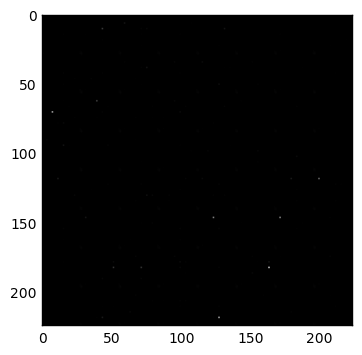

Epoch 1/2... Discriminator Loss: 0.3302... Generator Loss: 8.8911
Epoch 1/2... Discriminator Loss: 0.3354... Generator Loss: 7.9489
Epoch 1/2... Discriminator Loss: 0.3290... Generator Loss: 7.9768
Epoch 1/2... Discriminator Loss: 0.3558... Generator Loss: 8.9545
Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 8.1535
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 8.6978
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 8.7671
Epoch 1/2... Discriminator Loss: 0.3273... Generator Loss: 8.7716
Epoch 1/2... Discriminator Loss: 0.3295... Generator Loss: 9.0658
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 9.3359


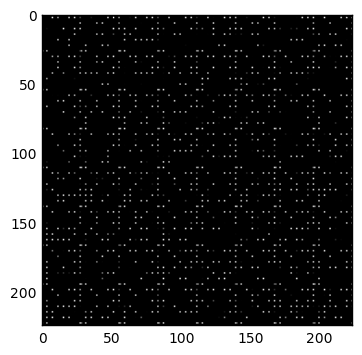

Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 9.5041
Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 9.2826
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 9.5362
Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 8.7002
Epoch 1/2... Discriminator Loss: 0.3327... Generator Loss: 9.2355
Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 9.1449
Epoch 1/2... Discriminator Loss: 0.3262... Generator Loss: 9.3362
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 9.5849
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.9903


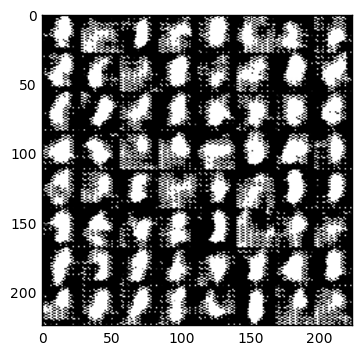

Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 4.4002
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 2.6601
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.3002
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.9394... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.8959
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.8519
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 2.3215
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.9007


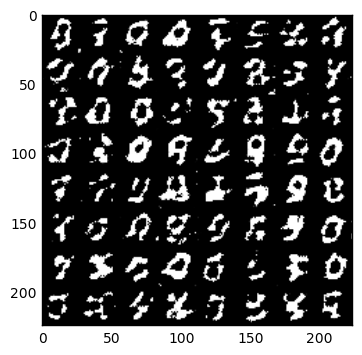

Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 2.5003
Epoch 1/2... Discriminator Loss: 1.7461... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 2.4374... Generator Loss: 7.0655
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 3.1886
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 3.5719
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 4.0229
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.2886
Epoch 2/2... Discriminator Loss: 0.3615... Generator Loss: 4.9061
Epoch 2/2... Discriminator Loss: 0.3903... Generator Loss: 3.8275
Epoch 2/2... Discriminator Loss: 0.3798... Generator Loss: 4.4987


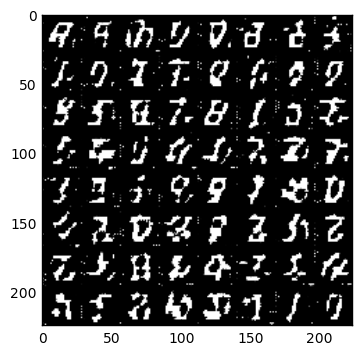

Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 3.7127
Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 2.1386
Epoch 2/2... Discriminator Loss: 0.4031... Generator Loss: 3.8828
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 3.7007
Epoch 2/2... Discriminator Loss: 1.4865... Generator Loss: 6.8147
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 3.3950
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.2420
Epoch 2/2... Discriminator Loss: 1.5143... Generator Loss: 0.6911


Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 1.6226
Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.2405... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.0279... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 1.9920
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9115
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.6825
Epoch 2/2... Discriminator Loss: 1.5759... Generator Loss: 0.5517


Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 1.7118
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.7181
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.4922
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.1023
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.5367
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.9820


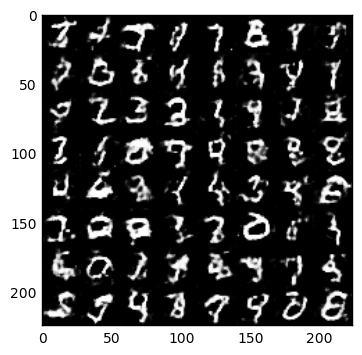

Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 1.6171
Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.9555
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.1047
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9477
Epoch 2/2... Discriminator Loss: 1.5472... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 1.3815
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 1.7570


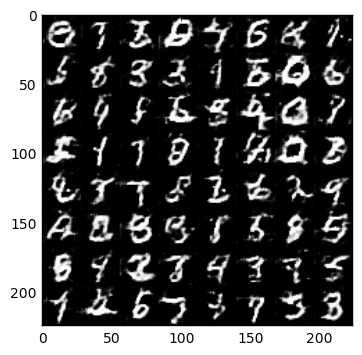

Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 1.7191
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.5245


IndexError: list index out of range

In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 10.0041
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 7.4399
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 7.7633
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 7.6682
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 8.3623
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 8.6056
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 8.8177
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 8.6427
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 3.8121


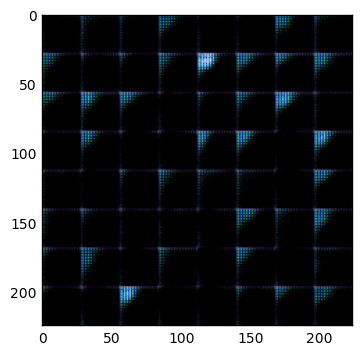

Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 5.2556
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 4.2669
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 8.3563
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 3.0842
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 3.2524
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.8330
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.8631
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 2.9169


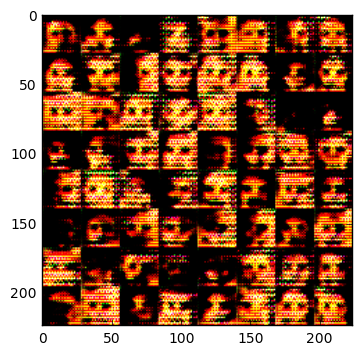

Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 4.3672
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.3378
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.7215
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.2529
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 4.1069
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 4.7845
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 2.0346
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.7866


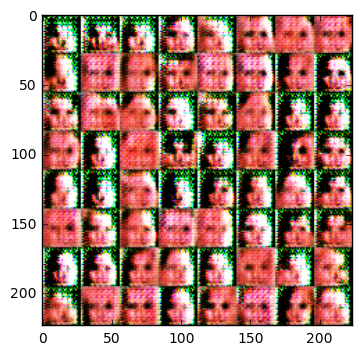

Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 2.3574
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 2.4923
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 2.2441... Generator Loss: 1.4780
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.9160


Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.6734
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.0462


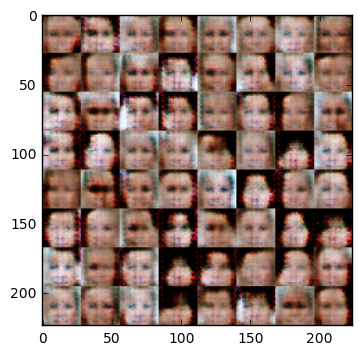

Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 1.8299
Epoch 1/1... Discriminator Loss: 2.1011... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.4766


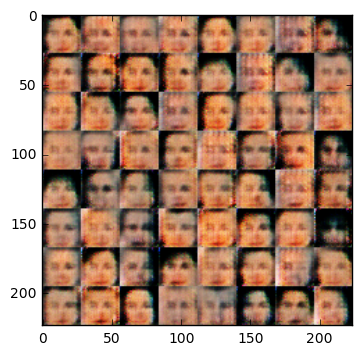

Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.9088


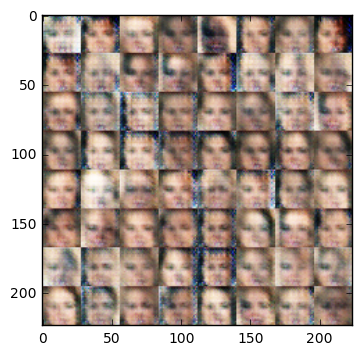

Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7410


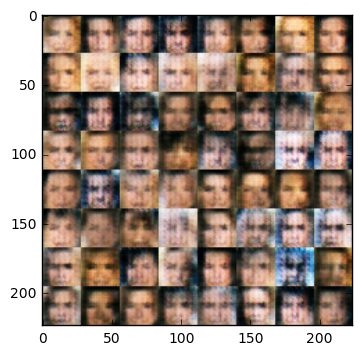

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.6935... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8022


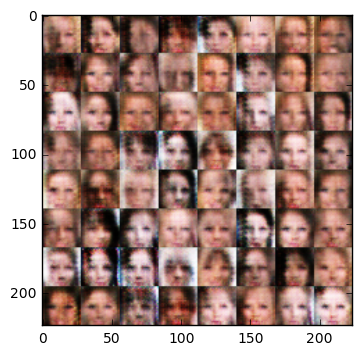

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8489


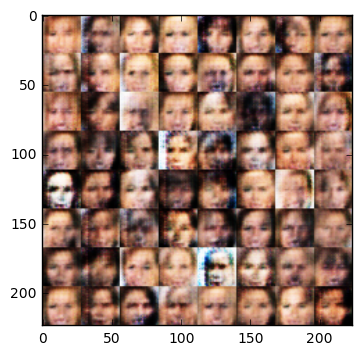

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7304


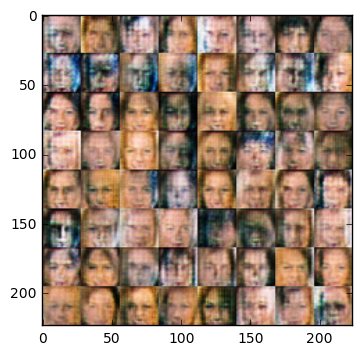

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8075


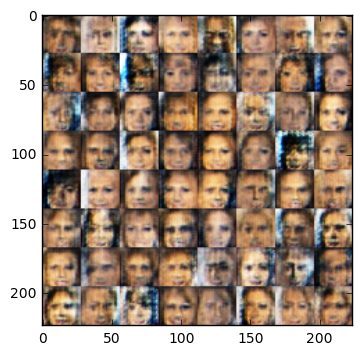

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.9025


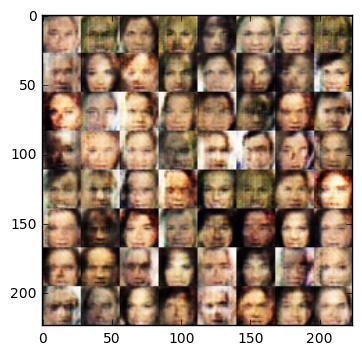

Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8038


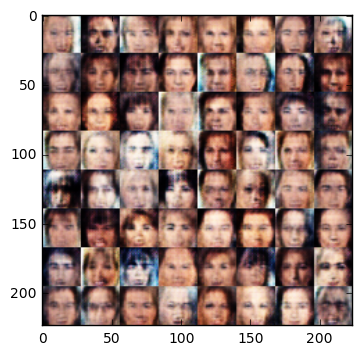

Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6842


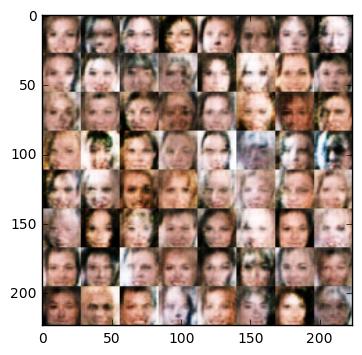

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.9345


IndexError: list index out of range

In [47]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.